# Imports and definitions

In [ ]:
import chromatic_tda as chro
import random
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import json

print(f'Loaded chromatic_tda version {chro.__version__}')

# Minimal example

## Load data

Run one of the following two cells: either generate a random chromatic point set or load an example

In [2]:
# Random chromatic point cloud
points = [[random.random(), random.random()] for _ in range(200)]
labels = [int(2*random.random()) for _ in points]

In [3]:
# Load example chromatic point cloud
with open('examples/chromatic_point_clouds/three_circles_2-colors_background.json','r') as file:
    data = json.load(file)
points, labels = data['points'], data['labels']

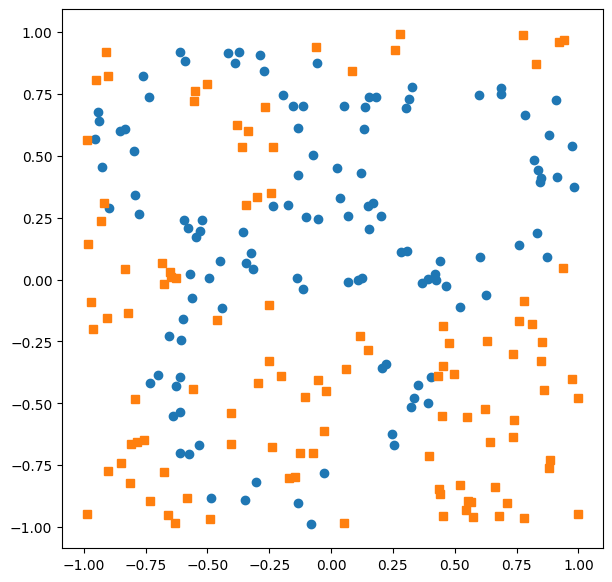

In [8]:
# Plot data
chro.plot_labeled_point_set(points, labels)
plt.show()

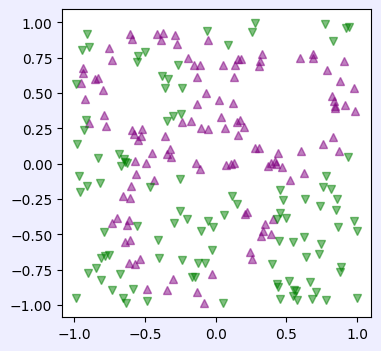

In [12]:
# The plot can also be adjusted with additional arguments
chro.plot_labeled_point_set(points, labels,
                            colors={0: 'purple', 1: 'green'},
                            markers={0: '^', 1: 'v'},
                            alpha=.5,
                            size=4,
                            facecolor='#eeeeff')
plt.show()

## From chromatic point cloud to a six-pack of persistence diagrams

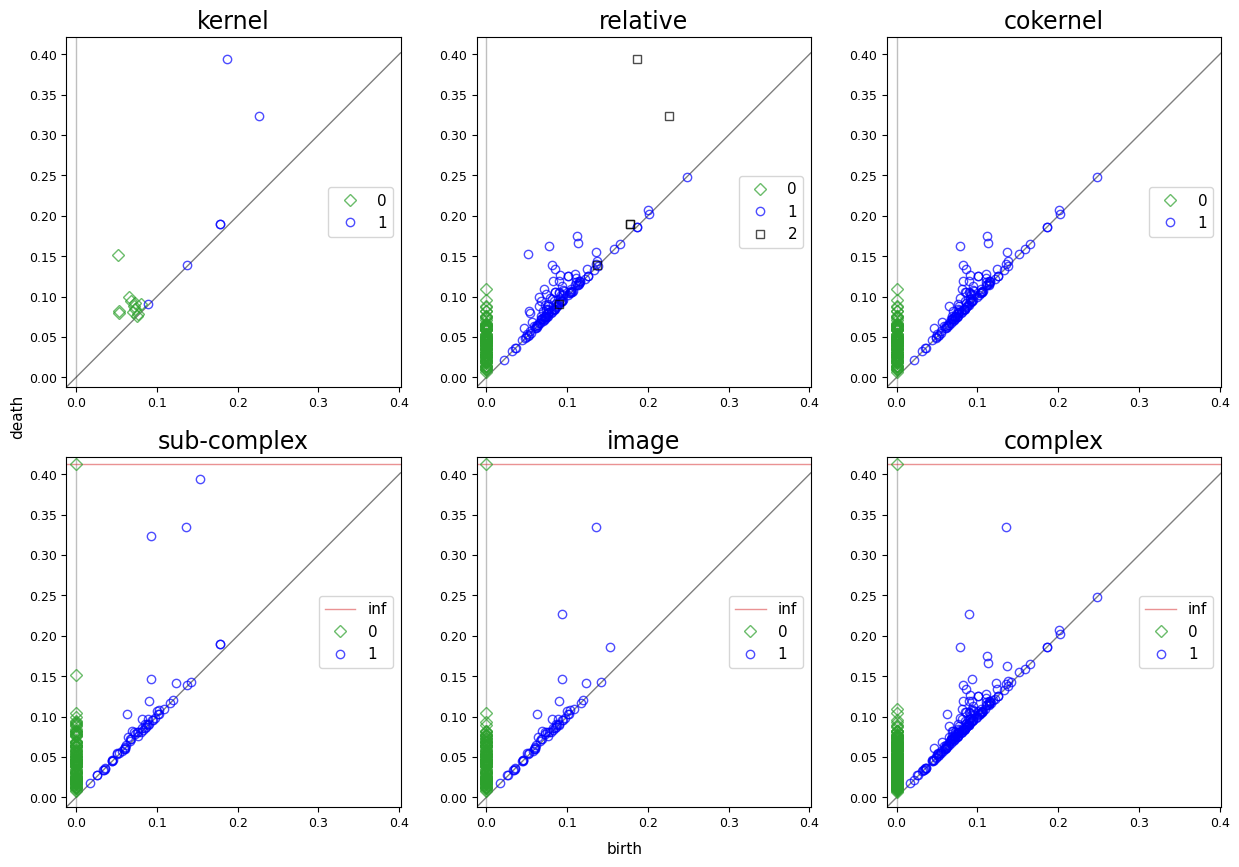

In [13]:
# Compute the chromatic Delaunay complex and extract the subcomplex-complex pair
alpha_complex = chro.ChromaticAlphaComplex(points, labels)
simplicial_complex = alpha_complex.get_simplicial_complex(sub_complex='0') # "0-labeled into all"

# Compute persistence, and show the six pack
simplicial_complex.compute_persistence() # optional, would be called automatically below
chro.plot_six_pack(simplicial_complex)
plt.show()

# More detailed example

Load chromatic point cloud as in the minimal example above. Points should be a list of pairs of numbers (currently only 2D point-clouds are allowed, adding 3D support is planed). Labels should be a list of hashable elements (integers, strings, ...) of the same length as the points. Currently there can be two or three different kind of labels.

We first create an instance of `ChromaticAlphaComplex` that computes the chromatic Delaunay complex and the chromatic alpha radii. Below we show various things to query from this object.

In [ ]:
alpha_complex = chro.ChromaticAlphaComplex(points, labels)

In [ ]:
# Get all simplices
simplices = alpha_complex.simplices()

# We also get one simplex to use below
simplex = sorted(simplices, key= lambda s: len(s))[-1]

In [ ]:
# Get the labels of a given simplex
alpha_complex.simplex_labels(simplex)

In [ ]:
# Get the points spanning the given simplex
alpha_complex.simplex_points(simplex)

In [ ]:
# Get the filtration value of the given simplex
alpha_complex.weight_function(simplex)

In [ ]:
# If no argument is given to `weight_function`, it returns a dictionary of all weights.
alpha_complex.weight_function()

From `ChromaticAlphaComplex` we get a `SimplicialComplex`, part of which is also a sub-complex. The pair is what the persistent homology is computed for. What complex and sub-complex is returned is controled by the parameters `complex`, `sub_complex`, and `relative` – see the docstring of the `get_simplicial_complex` method for details.

In [ ]:
simplicial_complex = alpha_complex.get_simplicial_complex(sub_complex='0')

`SimplicialComplex` does not store the points and labels anymore, only the simplicial pair as abstract simplicial complexes. It also has the `weight_function` that behaves as in the `ChromaticAlphaComplex`. You can get the set of all simplices with `.simplices()`, and the set of sub-complex simplices with `.simplices_sub_complex()`. You can query the membership in the complex by `simplex in simplicial_complex`, and membership in the sub-complex by `simplicial_complex.is_in_sub_complex(simplex)`.

To perform the persistent homology computations, call `simplicial_complex.compute_persistence()`. If not called manually, it is called automatically the first time the user extracts bars. It can be useful to call it manually to control where the bottleneck computation is performed.

In [ ]:
simplicial_complex.compute_persistence()

There are two ways to get bars: with `bars()` method and with `bars_six_pack()` method. See the respective docstrings for details.

In [ ]:
# You can get the list of the different groups for which persistence homology is computed like this:
simplicial_complex.GROUPS

In [ ]:
simplicial_complex.bars('kernel')

In [ ]:
simplicial_complex.bars_six_pack()

# Three colors

Everything works the same for three colors, there is just more options for the different (sub-complexes, complex) pairs to get.

In [3]:
# Random chromatic point cloud
points = [[random.random(), random.random()] for _ in range(200)]
labels = [int(3 * random.random()) for _ in points]

In [ ]:
# Load example chromatic point cloud
import json
with open('examples/chromatic_point_clouds/three_circles_3-colors.json','r') as file:
    data = json.load(file)
points, labels = data['points'], data['labels']

In [5]:
alpha_complex = chro.ChromaticAlphaComplex(points, labels)
simplicial_complex = alpha_complex.get_simplicial_complex(sub_complex='0,1,2', full_complex='01,02,12')
simplicial_complex.compute_persistence()

In [ ]:
chro.plot_six_pack(simplicial_complex)
plt.show()

# Define your own simplicial complex

You can also define your own abstract simplicial complex with an arbitrary weight function and subcomplex.

In [5]:
# Write a dictionary of simplices and filtration values.
# All subsimplices of the given simplices will be added with filtration value 0.
complex_simplices = {
    (0,)    : 0, # would be still added with weight 0 if not explicitly stated
    (1,)    : 0, # would be still added with weight 0 if not explicitly stated
    (2,)    : 0, # would be still added with weight 0 if not explicitly stated
    (0,1)   : 0, # would be still added with weight 0 if not explicitly stated
    (0,2)   : 0, # would be still added with weight 0 if not explicitly stated
    (1,2)   : 1,
    (3,)    : 2,
    (1,3)   : 2,
    (2,3)   : 2,
    (1,2,3) : 3,
    (0,1,2) : 4
}

# Define subcomplex by the maximal simplices 
sub_complex_max = {(0,1), (0,2), (1,3), (2,3)}
sub_complex = chro.SimplicialComplex(sub_complex_max).simplices() # compute the subsimplices

simplicial_complex = chro.SimplicialComplex(complex_simplices)
# We can also first define the complex and then give the filtration values by `simplicial_complex.set_simplex_weights(complex_simplices)`

simplicial_complex.set_sub_complex(sub_complex)
simplicial_complex.compute_persistence()

In [ ]:
# Print all non-trivial bars
print("Bars:")
for grp in simplicial_complex.GROUPS:
    print()
    print(f"  {grp}:")
    bars_all = simplicial_complex.bars(grp, return_as='dict')
    for dim, bars  in sorted(bars_all.items()):
        print(f"    dim {dim} ... ", end="")
        print(", ".join(str(bar) for bar in sorted(bars)))

# Six-pack for Vietoris-Rips complexes generated by Gudhi

Using the custom simplicial complex construction, we can compute six-packs for VR complexes generated by an external library.
Below is a code assuming `points` to be a list of points in any dimesnion and `labels` be an equaly long list of labels.

WARNING: Since we work with the VR-complex explicitely here, this is a VERY slow approach. You need to choose low enough maximum edge length and dimension, and work with not too many points.

[Needs version of chromatic_tda >= 1.0.6]

In [2]:
import gudhi

In [3]:
# Generate random data
n, dim, col = 50, 3, 2
points = np.random.random(size=(n, dim))
labels = [int(col * np.random.random()) for _ in range(len(points))]

In [4]:
max_edge_length = .6  # edge length cut-off threshold (note: infinite persistence features occur when birth <= max_edge_length < death)
max_dimension = 3  # dimension cut-off: persistent homology reliable for dimensions 0, 1, ..., max_dimension - 1
vr_complex_gudhi = gudhi.RipsComplex(points, max_edge_length=max_edge_length).create_simplex_tree(max_dimension=max_dimension)
vr_complex_radius_function = {tuple(sorted(simplex)): radius for simplex, radius in vr_complex_gudhi.get_filtration()}
vr_complex_chro = chro.SimplicialComplex(vr_complex_radius_function)
simplicial_complex = vr_complex_chro.get_chromatic_subcomplex(
            labeling=labels, sub_complex='0', full_complex='all', relative='')

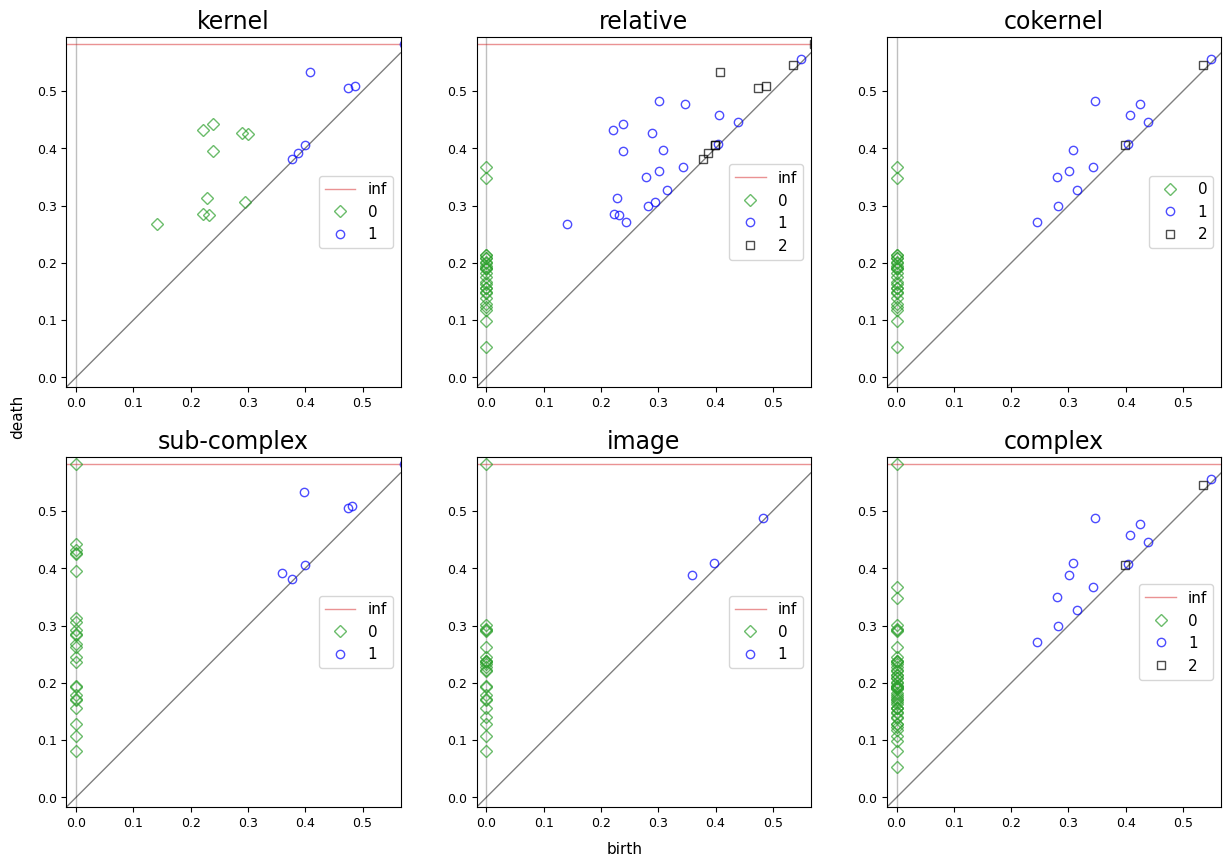

In [5]:
simplicial_complex.compute_persistence()
chro.plot_six_pack(simplicial_complex, max_dimension=max_dimension-1)
plt.show()

# Plotting functions

Both `plot_six_pack` and `plot_persistence_diagram` functions in `chromatic_tda` return the figure and axes, and can also take many keyword arguments from the `matplotlib`. Below is an example of a customised six pack plot.

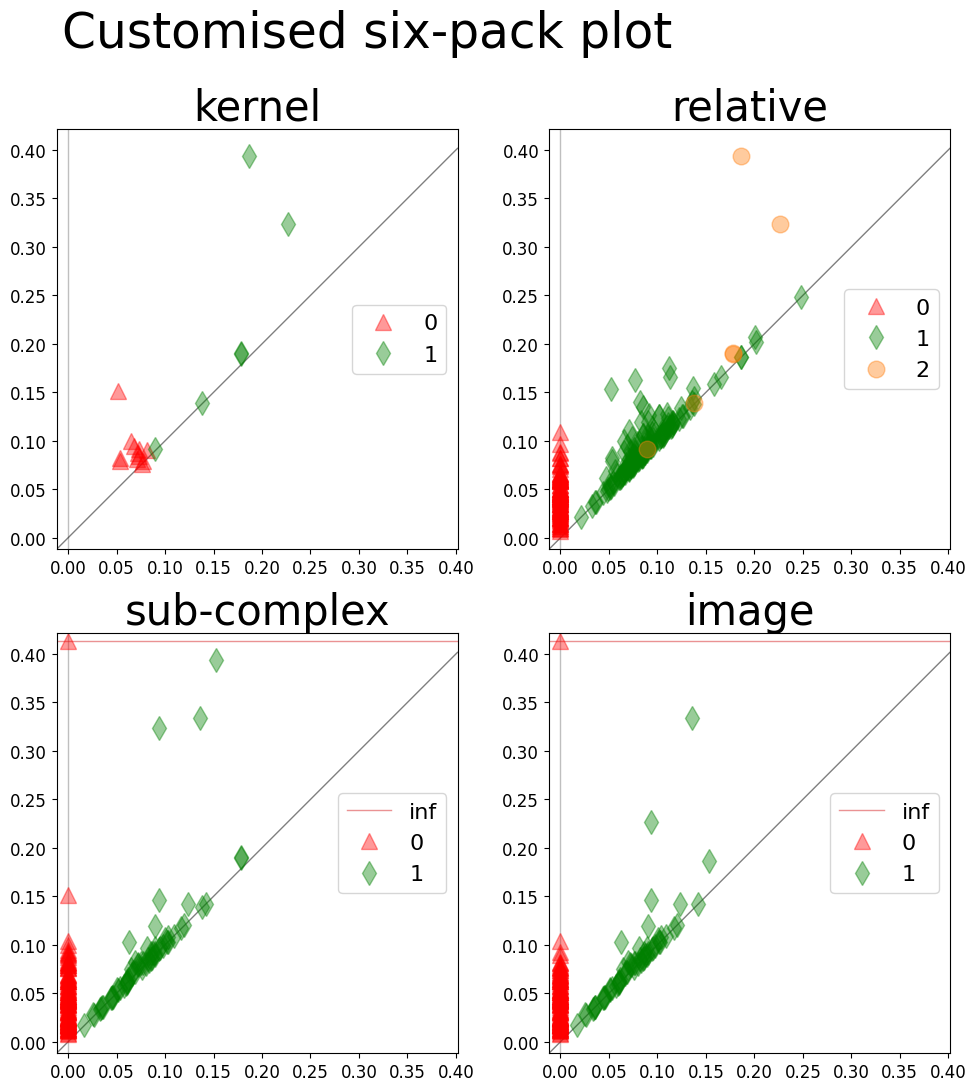

In [7]:
fig, axs = chro.plot_six_pack(simplicial_complex,
                   size=6,
                   title_fontsize=30,
                   ticks_fontsize=12,
                   legend_fontsize=16,
                   marker={0:'^', 1:'d'},
                   color={0:'red', 1:'green', 2:'tab:orange'},
                   fillstyle='full',
                   markersize=12,
                   alpha=.4,
                   axes_labels=False)
axs[2].set_visible(False)
axs[5].set_visible(False)
fig.suptitle("Customised six-pack plot", fontsize=35, x=0.3)
plt.show()

# Experimental: Feature extraction (get loops back from diagrams)

A very important aspect of using persistence homology is going back to data and interpret the identified features.

One caveat is that a "feature" is not a single loop, but a class of loops, and even worse, this class is a "dimension" of a vector space rather than a concrete element of it. This means that there is many options for "the loop that corresponds to a persistence bar".

While there is no single cannonical choice, there are some choices that are meaningful and easy to obtain from the computations we perform. Below we show how to extract and plot a loop.

## Set up

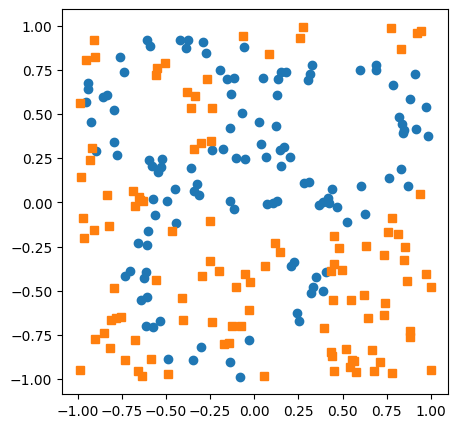

In [2]:
# We work with the three-loop point set
with open('examples/chromatic_point_clouds/three_circles_2-colors_background.json','r') as file:
    data = json.load(file)
points, labels = data['points'], data['labels']
chro.plot_labeled_point_set(points, labels, size=5)
plt.show()

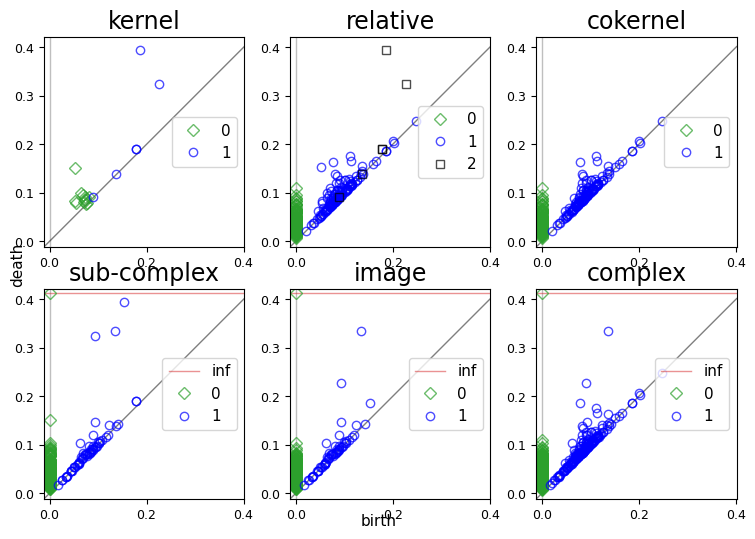

In [3]:
# Set up the complexes, compute persistence and show the six-pack
alpha = chro.ChromaticAlphaComplex(points, labels)
simplicial_complex = alpha.get_simplicial_complex(sub_complex='0')
chro.plot_six_pack(simplicial_complex, size = 3)
plt.show()

In [4]:
# We set up the feature extractor
feature_extractor = chro.experimental.feature_extraction.FeatureExtractor(simplicial_complex)

## Most persistent features

In [5]:
# Let's first plot the three largest loops in the 'complex' diagram
# We extract persistence pairs as the simplices giving birth and death (rather than the birth-death values).
# We let them be sorted by 'persistence', that is, by the length of the correxponding bars. This is the default option.
# We take the three most persistant.
top_three_features = feature_extractor.persistence_pairs(group='complex', dim=1, sorted_by='persistence')[:3]
top_three_features

[((60, 182), (79, 220, 226)),
 ((39, 50), (124, 169, 198)),
 ((10, 56), (41, 67, 210))]

In [6]:
# We extract corresponding loops
loops = [feature_extractor.extract_feature(death, group='complex') for birth, death in top_three_features]

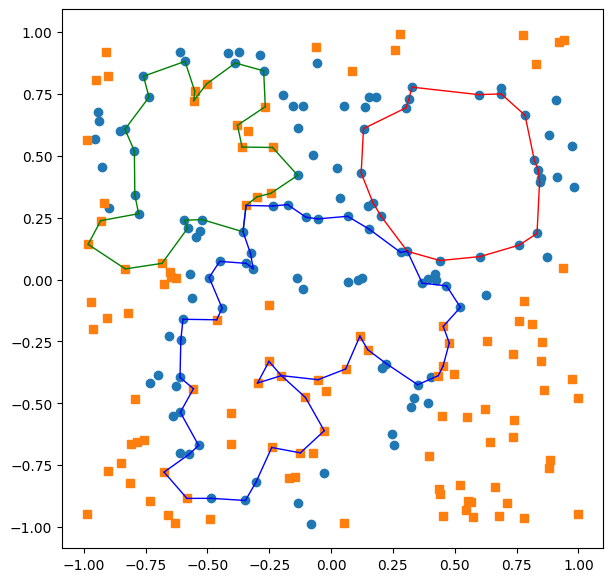

In [7]:
# Finally, we plot the three features in red, green and blue, into the point set plot.
# Note that each line outputs the axis, and we pass it in the ax argument of the next line.
fig, ax = chro.plot_labeled_point_set(points, labels)
fig, ax = chro.plot_edges(points, loops[0], ax=ax, color='red')
fig, ax = chro.plot_edges(points, loops[1], ax=ax, color='green')
fig, ax = chro.plot_edges(points, loops[2], ax=ax, color='blue')
plt.show()

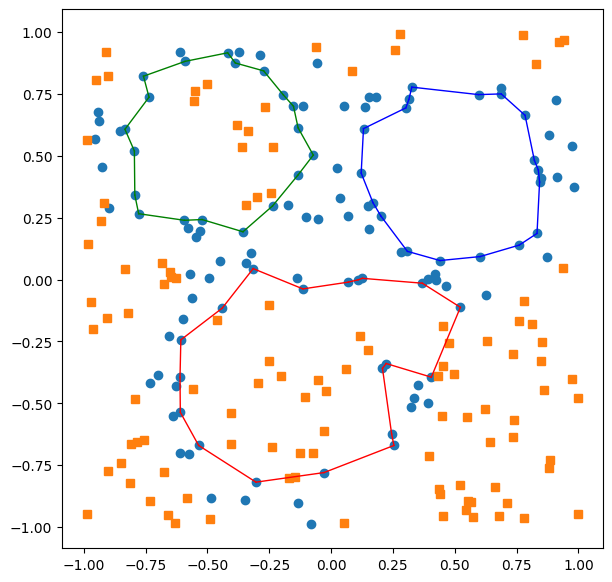

In [8]:
# Now we do the same for the blue sub-complex
top_three_features = feature_extractor.persistence_pairs(group='sub_complex', dim=1, sorted_by='persistence')[:3]
loops = [feature_extractor.extract_feature(death, group='sub_complex') for birth, death in top_three_features]
fig, ax = chro.plot_labeled_point_set(points, labels)
fig, ax = chro.plot_edges(points, loops[0], ax=ax, color='red')
fig, ax = chro.plot_edges(points, loops[1], ax=ax, color='green')
fig, ax = chro.plot_edges(points, loops[2], ax=ax, color='blue')
plt.show()

## Particular feature from a diagram

If we want to extract a particular feature from a diagram, we can identify it with the birth-death coordinates. We can either get the coordinates directly from `simplicial_complex.bars(...)` or guess a nearby value. Either way we can get persistence pairs sorted by the proximity from those coordinates in the diagram.

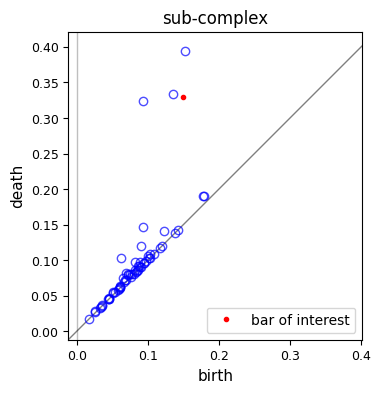

In [33]:
# our guess of where the middle of the three large features in the sub-complex diagram are

bar_of_interest = [0.15, 0.33]

chro.plot_persistence_diagram(simplicial_complex.bars('sub_complex', 1), size=4, color='blue')
plt.plot(*bar_of_interest, linestyle='none', marker='o', markersize=3, color='red', label='bar of interest')
plt.legend()
plt.title('sub-complex')
plt.show()

In [37]:
# Now we extract the pair with birth-death value the closest to the defined:
pair = feature_extractor.persistence_pairs('sub_complex', 1, sorted_by='proximity', bar_of_interest=[0.15, 0.33])[0]

In [38]:
# We can also check the values:
(simplicial_complex.weight_function(pair[0]), simplicial_complex.weight_function(pair[1]))

(np.float64(0.13557933311994755), np.float64(0.33434058205436484))

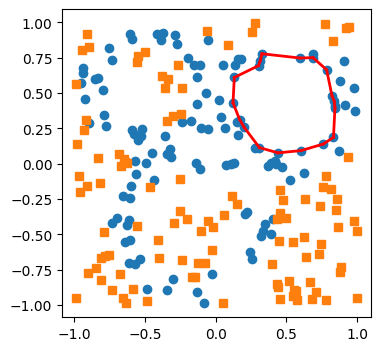

In [43]:
# Finally, we extract the loop and plot it
loop = feature_extractor.extract_feature(pair[1], 'sub_complex')
fig, ax = chro.plot_labeled_point_set(points, labels, size=4)
chro.plot_edges(points, loop, ax=ax, color='red', linewidth=2)
plt.show()

We can see that it is the one that is not filled by orange points at all---this makes sense looking back at the six-pack, where we see that the same dots appears also in the image and complex diagrams. We can extract the same feature from those diagrams and visually compare.

In this example, indeed, they all overlap. This might not be the case even if it is still the same feature, due to the freedom of choice of a loop representative, as mentioned in the intro to this section.

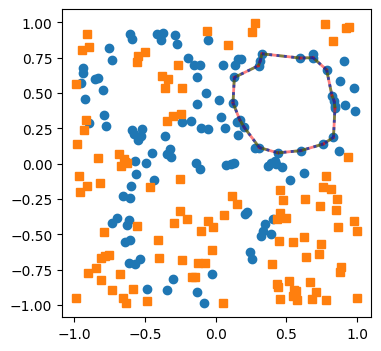

In [48]:
pair_sub = feature_extractor.persistence_pairs('sub_complex', 1, sorted_by='proximity', bar_of_interest=[0.15, 0.33])[0]
loop_sub = feature_extractor.extract_feature(pair[1], 'sub_complex')

pair_im = feature_extractor.persistence_pairs('image', 1, sorted_by='proximity', bar_of_interest=[0.15, 0.33])[0]
loop_im = feature_extractor.extract_feature(pair[1], 'image')

pair_cplx = feature_extractor.persistence_pairs('complex', 1, sorted_by='proximity', bar_of_interest=[0.15, 0.33])[0]
loop_cplx = feature_extractor.extract_feature(pair[1], 'complex')

# Finally, we extract the loop and plot it
loop = feature_extractor.extract_feature(pair[1], 'sub_complex')
fig, ax = chro.plot_labeled_point_set(points, labels, size=4)
fig, ax = chro.plot_edges(points, loop_sub, ax=ax, color='red', linewidth=2, alpha=.5)
fig, ax = chro.plot_edges(points, loop_im, ax=ax, color='green', linewidth=2, linestyle='--', alpha=.5)
fig, ax = chro.plot_edges(points, loop_cplx, ax=ax, color='blue', linewidth=2, linestyle=':', alpha=.5)
plt.show()

## Kernel

Lastly, we move to kernel, and check that the two largest kernel features are the one completely filled and the one partially filled by orange points.

In [53]:
top_two_kernel_pairs = feature_extractor.persistence_pairs('kernel', 1)[:2]
loops = [feature_extractor.extract_feature(pair[1], 'kernel') for pair in top_two_kernel_pairs]

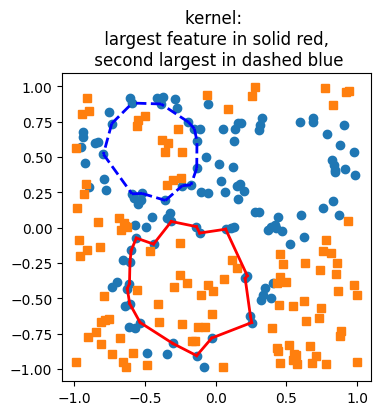

In [68]:
# Finally, we extract the loop and plot it
loop = feature_extractor.extract_feature(pair[1], 'sub_complex')
fig, ax = chro.plot_labeled_point_set(points, labels, size=4)
chro.plot_edges(points, loops[0], ax=ax, color='red', linewidth=2)
chro.plot_edges(points, loops[1], ax=ax, color='blue', linestyle='--', linewidth=2)
plt.title('kernel: \n largest feature in solid red, \n second largest in dashed blue')
plt.show()